<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/learn-pytorch/zero_to_mastery_learn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

torch.__version__

'1.13.1+cu116'

In [2]:
!nvidia-smi

Tue Jan 31 01:25:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [246]:
!pip install torchvision torchinfo tensorboardx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Utils

In [4]:
import torch
from torch.utils.data import DataLoader
from torch import nn

In [5]:
def train_step(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    accuracy_fn,
    device: torch.device = device,
    debug=False
):
  loss, acc = 0, 0
  model.train()
  for batch_idx, (x, y) in tqdm(enumerate(data_loader)):
    x, y = x.to(device), y.to(device)
    train_probs = model(x)
    batch_loss = loss_fn(train_probs, y)
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    loss += batch_loss
    train_preds = train_probs.argmax(dim=-1)
    batch_acc = accuracy_fn(y, train_preds)
    acc += batch_acc
    if debug and batch_idx % 250 == 0:
      print(f"Batch {batch_idx} Loss: {batch_loss:.5f} | Train accuracy: {batch_acc:.2f}%")
  loss /= len(data_loader)
  acc /= len(data_loader)
  print(f"Train loss: {loss:.5f} | Train accuracy: {acc:.2f}%")
  return loss, acc

In [6]:
def test_step(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    accuracy_fn,
    device: torch.device = device,
    debug=False
):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(data_loader):
      x, y = x.to(device), y.to(device)
      probs = model(x)
      batch_loss = loss_fn(probs, y)
      loss += batch_loss
      preds = probs.argmax(dim=-1)
      batch_acc = accuracy_fn(y, preds)
      acc += batch_acc
      if debug and batch_idx % 250 == 0:
        print(f"Batch {batch_idx} Loss: {batch_loss:.5f} | Test accuracy: {batch_acc:.2f}%")
    loss /= len(data_loader)
    acc /= len(data_loader)
  print(f"Test loss: {loss:.5f} | Test accuracy: {acc:.2f}%")
  return loss, acc

In [7]:
def train(model, loss_fn, optimizer, accuracy_fn, epochs, train_dataloader, test_dataloader, device=device):
  epochs = range(EPOCHS)
  history = dict(
    train_loss=[],
    test_loss=[], 
    train_acc=[],
    test_acc=[]
  )
  
  for epoch in epochs:
    etrain_loss, etrain_acc = train_step(
      model=model, 
      data_loader=train_dataloader, 
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      accuracy_fn=accuracy_fn,
    )
    history["train_loss"].append(etrain_loss.to("cpu").detach().numpy())
    history["train_acc"].append(etrain_acc.to("cpu").detach().numpy())
    etest_loss, etest_acc = test_step(
      model=model, 
      data_loader=test_dataloader, 
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      accuracy_fn=accuracy_fn,  
    )
    history["test_loss"].append(etest_loss.to("cpu").detach().numpy())
    history["test_acc"].append(etest_acc.to("cpu").detach().numpy())
  return history

In [38]:
def plot_history(train_losses, test_losses=None, train_acc=None, test_acc=None):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  epochs = list(range(1, len(train_losses)+1))
  plt.plot(epochs, train_losses, label="Train")
  if test_losses:
    plt.plot(epochs, test_losses, label="Test")
  plt.title("Loss by epoch")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="Train")
  if test_losses:
    plt.plot(epochs, test_acc, label="Test")
  plt.title("Accuracy by epoch")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()

# 00 Pytorch fundamentals

In [253]:
# 2
t = torch.rand(7, 7)
print(f"{t.shape=}")

t.shape=torch.Size([7, 7])


In [254]:
# 3
t2 = torch.rand(1, 7)
t @ t2.T

tensor([[1.7977],
        [1.4399],
        [1.9632],
        [1.5714],
        [1.3151],
        [1.6300],
        [1.7768]])

In [255]:
# 4
torch.manual_seed(0)

In [256]:
# 5
if torch.cuda.is_available():
  torch.cuda.random.manual_seed(0)

In [257]:
# 8, 9
t3 = torch.rand(3, 5)
out, idx = t3.max(axis=0)
assert out.shape == torch.Size([5])

In [258]:
# 10
t4 = torch.rand(1, 1, 1, 10)
t4.view(10)

tensor([0.5185, 0.6977, 0.8000, 0.1610, 0.2823, 0.6816, 0.9152, 0.3971, 0.8742,
        0.4194])

# 01 PyTorch Workflow Fundamentas

In [259]:
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path

In [260]:
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, step=0.02).unsqueeze(1)
y = weight * X + bias + torch.rand(X.shape) * 0.2

In [261]:
split = int(0.8 * X.shape[0])
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:] 

In [262]:
def plot_predictions(
    train_data,
    train_labels,
    test_data,
    test_labels,
    predictions=None,
):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Train data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend(prop={"size": 14})

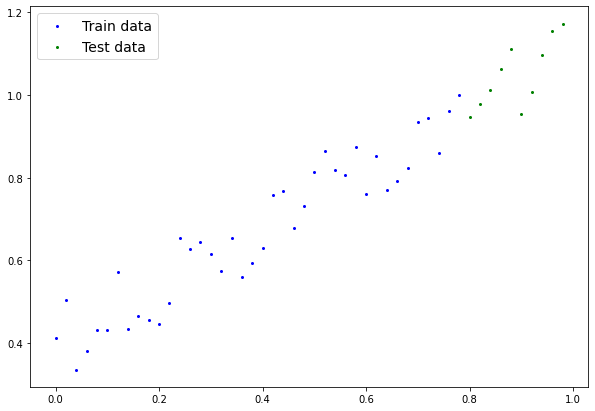

In [263]:
plot_predictions(X_train, y_train, X_test, y_test)

In [264]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1, dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.rand(1, dtype=torch.float), requires_grad=True)
  def forward(self, x: torch.Tensor):
    return self.weights * x + self.bias

In [265]:
torch.manual_seed(13)
model_0 = LinearModel()
with torch.inference_mode():
  y_preds = model_0(X_test)

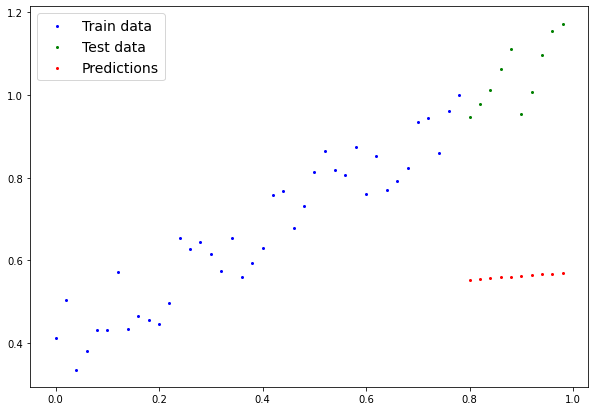

In [266]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [267]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)

In [268]:
num_epochs = 100
epochs, train_losses, test_losses = [], [], []

for epoch in range(num_epochs):
  model_0.train()
  y_pred = model_0(X_train)
  train_loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)
    epochs.append(epoch)
    train_losses.append(train_loss.detach().numpy())
    test_losses.append(test_loss.detach().numpy())
    if epoch % 5 == 0:
      print("Epoch: %i Loss %.2f Test Loss %.2f" % (epoch, train_loss, test_loss))

Epoch: 0 Loss 0.18 Test Loss 0.45
Epoch: 5 Loss 0.13 Test Loss 0.31
Epoch: 10 Loss 0.11 Test Loss 0.26
Epoch: 15 Loss 0.11 Test Loss 0.24
Epoch: 20 Loss 0.10 Test Loss 0.21
Epoch: 25 Loss 0.09 Test Loss 0.19
Epoch: 30 Loss 0.08 Test Loss 0.18
Epoch: 35 Loss 0.08 Test Loss 0.16
Epoch: 40 Loss 0.07 Test Loss 0.15
Epoch: 45 Loss 0.07 Test Loss 0.13
Epoch: 50 Loss 0.07 Test Loss 0.12
Epoch: 55 Loss 0.07 Test Loss 0.11
Epoch: 60 Loss 0.07 Test Loss 0.11
Epoch: 65 Loss 0.06 Test Loss 0.11
Epoch: 70 Loss 0.06 Test Loss 0.10
Epoch: 75 Loss 0.06 Test Loss 0.09
Epoch: 80 Loss 0.06 Test Loss 0.09
Epoch: 85 Loss 0.06 Test Loss 0.08
Epoch: 90 Loss 0.06 Test Loss 0.07
Epoch: 95 Loss 0.06 Test Loss 0.07


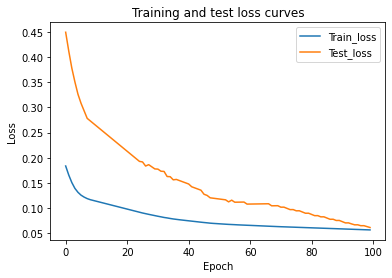

In [269]:
plt.plot(epochs, train_losses, label="Train_loss")
plt.plot(epochs, test_losses, label="Test_loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

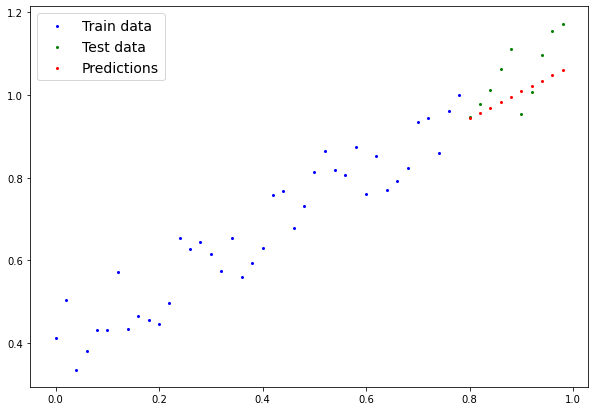

In [270]:
with torch.inference_mode():
  y_preds = model_0(X_test)
  
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [271]:
OUTPUT_PATH = Path("models")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
file_path = OUTPUT_PATH / "linear_model.pt"
torch.save(obj=model_0.state_dict(), f=file_path)

In [272]:
model_0_from_saved = LinearModel()
model_0_from_saved.load_state_dict(state_dict=torch.load(file_path))

<All keys matched successfully>

# 02 PyTorch Neural Network Classification

In [273]:
import numpy as np
from sklearn.datasets import make_circles

In [274]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [275]:
print(f"{X.shape=}")
print(f"{y.shape=}")

X.shape=(1000, 2)
y.shape=(1000,)


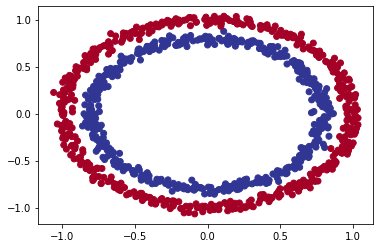

In [276]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [277]:
X_pt = torch.from_numpy(X).type(torch.float)
y_pt = torch.from_numpy(y).type(torch.float)

In [278]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pt, y_pt, test_size=0.2, random_state=32)

In [279]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(in_features=2, out_features=16, dtype=torch.float)
    self.l2 = nn.Linear(in_features=16, out_features=16, dtype=torch.float)
    self.l3 = nn.Linear(in_features=16, out_features=1, dtype=torch.float)
    self.relu = nn.ReLU()
    self.activation = nn.Sigmoid()

  def forward(self, x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.activation(x)
    return x

In [280]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct / y_true.shape[0] * 100

In [281]:
model_0 = CircleModel().to(device)
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [282]:
num_epochs = 100

epochs = range(num_epochs)
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

tmpl = "Epoch %i Loss %.2f Accuracy %.2f Test Loss %.2f Test Accuracy %.2f"

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in epochs:
  model_0.train()
  probs_train = model_0(X_train).squeeze()
  preds_train = torch.round(probs_train)
  loss_train = nn.BCELoss()(probs_train, y_train)
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()
  train_losses.append(loss_train)
  accuracy_train = accuracy(y_train, preds_train)
  train_accuracies.append(accuracy_train)
  model_0.eval()
  with torch.inference_mode():
    probs_test = model_0(X_test).squeeze()
    preds_test = torch.round(probs_test)
    loss_test = nn.BCELoss()(probs_test, y_test)
  test_losses.append(loss_test)
  accuracy_test = accuracy(y_test, preds_test)
  test_accuracies.append(accuracy_test)
  if epoch % 5 == 0:
    print(tmpl % (epoch, loss_train, accuracy_train, loss_test, accuracy_test))
  

Epoch 0 Loss 0.70 Accuracy 50.12 Test Loss 0.70 Test Accuracy 49.50
Epoch 5 Loss 0.69 Accuracy 49.88 Test Loss 0.69 Test Accuracy 50.50
Epoch 10 Loss 0.69 Accuracy 52.00 Test Loss 0.69 Test Accuracy 51.50
Epoch 15 Loss 0.68 Accuracy 59.00 Test Loss 0.68 Test Accuracy 53.00
Epoch 20 Loss 0.67 Accuracy 61.38 Test Loss 0.67 Test Accuracy 55.00
Epoch 25 Loss 0.65 Accuracy 63.00 Test Loss 0.66 Test Accuracy 56.00
Epoch 30 Loss 0.62 Accuracy 68.12 Test Loss 0.64 Test Accuracy 62.00
Epoch 35 Loss 0.59 Accuracy 78.50 Test Loss 0.60 Test Accuracy 80.00
Epoch 40 Loss 0.54 Accuracy 91.25 Test Loss 0.54 Test Accuracy 91.00
Epoch 45 Loss 0.47 Accuracy 98.88 Test Loss 0.47 Test Accuracy 98.50
Epoch 50 Loss 0.39 Accuracy 99.62 Test Loss 0.40 Test Accuracy 100.00
Epoch 55 Loss 0.31 Accuracy 99.50 Test Loss 0.32 Test Accuracy 100.00
Epoch 60 Loss 0.24 Accuracy 99.75 Test Loss 0.24 Test Accuracy 100.00
Epoch 65 Loss 0.17 Accuracy 99.75 Test Loss 0.18 Test Accuracy 100.00
Epoch 70 Loss 0.12 Accuracy 100.

In [283]:
model_0.eval()
with torch.inference_mode():
  probs_test = model_0(X_test).squeeze()
  preds_test = torch.round(probs_test)

print(f"{preds_test[:15]=}".rjust(85))
print(f"{y_test[:15]=}".rjust(85))

preds_test[:15]=tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')
y_test[:15]=tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')


In [284]:
def plot_decision_boundary(model, X, y):
  # setup mesh
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(
    np.linspace(x_min.to("cpu"), x_max.to("cpu"), 1001), 
    np.linspace(y_min.to("cpu"), y_max.to("cpu"), 1001),
  )
  # reshape data
  X_mesh = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
  # predict
  model_0.eval()
  with torch.inference_mode():
    probs_mesh = model_0(X_mesh.to(device)).squeeze()
    preds_mesh = torch.round(probs_mesh)
  # reshape back
  preds_mesh_reshaped = preds_mesh.reshape(xx.shape)
  # plot
  plt.contourf(xx, yy, preds_mesh_reshaped.to("cpu"), cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0].to("cpu"), X[:, 1].to("cpu"), c=y.to("cpu"), s=40, cmap=plt.cm.RdYlBu)

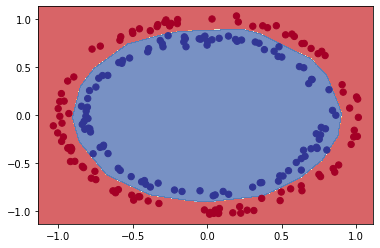

In [285]:
plot_decision_boundary(model=model_0, X=X_test, y=y_test)

# 03 PyTorch Computer Vision

In [286]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 13.9 MB/s eta 0:00:00


In [287]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import torchmetrics

import matplotlib.pyplot as plt

from tqdm import tqdm

In [288]:
ROOT_DATA_FOLDER = "data"

def get_fashion_mnist(split: str, data_folder=ROOT_DATA_FOLDER):
  return datasets.FashionMNIST(
      root=data_folder,
      train=(True if split.lower() == "train" else False),
      download=True,
      transform=ToTensor(),
      target_transform=None,
  )  

train_data = get_fashion_mnist(split="train")
test_data = get_fashion_mnist(split="test")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [289]:
len(train_data), len(test_data)

(60000, 10000)

In [290]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [291]:
class FashionClassifier(nn.Module):
  def __init__(self, input_channels, hidden_units, num_classes):
    super().__init__()
    self.kernel_size = 3
    self.stride = 2
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=self.kernel_size, padding="same"),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.kernel_size, padding="same"),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride),
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.kernel_size, padding="same"),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.kernel_size, padding="same"),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(in_features=hidden_units*6*6, out_features=num_classes),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.classifier(x)
    return x

In [292]:
INPUT_CHANNELS = train_data[0][0].shape[0]
HIDDEN_UNITS = 64
NUM_CLASSES = len(train_data.classes)

print(f"{INPUT_CHANNELS=}, {HIDDEN_UNITS=}, {NUM_CLASSES=}")

INPUT_CHANNELS=1, HIDDEN_UNITS=64, NUM_CLASSES=10


In [293]:
model_0 = FashionClassifier(INPUT_CHANNELS, HIDDEN_UNITS, NUM_CLASSES).to(device)
model_0

FashionClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=2304, out_features=10, bias=True)
  )
)

In [294]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [295]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.005)

In [296]:
def train_step(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    accuracy_fn,
    device: torch.device = device,
    debug=False
):
  loss, acc = 0, 0
  model.train()
  for batch_idx, (x, y) in tqdm(enumerate(data_loader)):
    x, y = x.to(device), y.to(device)
    train_probs = model(x)
    batch_loss = loss_fn(train_probs, y)
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    loss += batch_loss
    train_preds = train_probs.argmax(dim=-1)
    batch_acc = accuracy_fn(y, train_preds)
    acc += batch_acc
    if debug and batch_idx % 250 == 0:
      print(f"Batch {batch_idx} Loss: {batch_loss:.5f} | Train accuracy: {batch_acc:.2f}%")
  loss /= len(data_loader)
  acc /= len(data_loader)
  print(f"Train loss: {loss:.5f} | Train accuracy: {acc:.2f}%")
  return loss, acc

In [297]:
def test_step(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    accuracy_fn,
    device: torch.device = device,
    debug=False
):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(data_loader):
      x, y = x.to(device), y.to(device)
      probs = model(x)
      batch_loss = loss_fn(probs, y)
      loss += batch_loss
      preds = probs.argmax(dim=-1)
      batch_acc = accuracy_fn(y, preds)
      acc += batch_acc
      if debug and batch_idx % 250 == 0:
        print(f"Batch {batch_idx} Loss: {batch_loss:.5f} | Test accuracy: {batch_acc:.2f}%")
    loss /= len(data_loader)
    acc /= len(data_loader)
  print(f"Test loss: {loss:.5f} | Test accuracy: {acc:.2f}%")
  return loss, acc

In [298]:
EPOCHS = 5

epochs = range(EPOCHS)
train_loss, test_loss, train_acc, test_acc, = [], [], [], [],  

for epoch in epochs:
  etrain_loss, etrain_acc = train_step(
    model=model_0, 
    data_loader=train_dataloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    accuracy_fn=accuracy,
  )
  train_loss.append(etrain_loss.to("cpu").detach().numpy())
  train_acc.append(etrain_acc)
  etest_loss, etest_acc = test_step(
    model=model_0, 
    data_loader=train_dataloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    accuracy_fn=accuracy,  
  )
  test_loss.append(etest_loss.to("cpu").detach().numpy())
  test_acc.append(etest_acc)

938it [00:19, 49.24it/s]


Train loss: 0.52780 | Train accuracy: 80.41%
Test loss: 0.34594 | Test accuracy: 86.85%


938it [00:11, 84.58it/s]


Train loss: 0.35790 | Train accuracy: 86.78%
Test loss: 0.31683 | Test accuracy: 88.38%


938it [00:11, 84.49it/s]


Train loss: 0.31735 | Train accuracy: 88.49%
Test loss: 0.26165 | Test accuracy: 90.39%


938it [00:11, 84.69it/s]


Train loss: 0.29367 | Train accuracy: 89.31%
Test loss: 0.24582 | Test accuracy: 90.96%


938it [00:11, 82.11it/s]


Train loss: 0.27970 | Train accuracy: 89.83%
Test loss: 0.28314 | Test accuracy: 89.51%


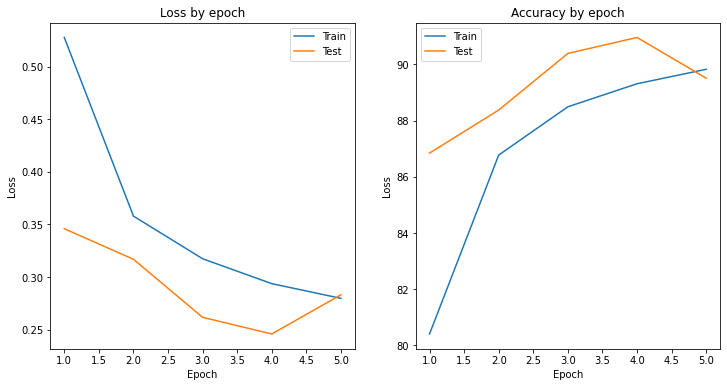

In [299]:
plot_history(train_loss, test_loss, train_acc, test_acc)

# 04 Custom Datasets

In [33]:
import PIL
from pathlib import Path
import requests
import zipfile
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


from torchvision import datasets, transforms, models

from torch.utils.data import Dataset, DataLoader
from torch import nn

import torchinfo

In [10]:
data_path = Path("data") 
image_path = data_path / "pizza_steak_sushi"
image_path.mkdir(parents=True, exist_ok=True)
zip_path = data_path / "pizza_steak_sushi.zip"

url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
response = requests.get(url)

with open(zip_path, "wb") as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_path)

### Use built-in dataset loader

In [11]:
IMG_SIZE = (224, 224)

transform_train = transforms.Compose([
    transforms.Resize(size=IMG_SIZE),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.Resize(size=IMG_SIZE),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

In [12]:
ds = datasets.ImageFolder(root=image_path / "train", transform=transform_train)

### Use custom dataset

In [13]:
class CustomDataset(Dataset):

  def __init__(self, path, transform=None):
    self.path = path
    self.images = list((path).glob("**/*.jpg"))
    self.num_images = len(self.images)
    self.transform = transform
    self.class_to_idx = {v.stem: k for k, v in enumerate(path.glob("*"))}

  def __len__(self,):
    return self.num_images

  def __getitem__(self, index):
    img_path = self.images[index]
    image = PIL.Image.open(img_path)
    return (
      (self.transform(image) if self.transform else image), 
      self.class_to_idx[img_path.parent.stem]
    )

In [14]:
weights = models.ViT_B_16_Weights.DEFAULT

In [15]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
IMG_SIZE = (224, 224)

transform_train = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    weights.transforms(),
])
transform_test = transforms.Compose([
    weights.transforms(),
])

ds_train = CustomDataset(image_path / "train", transform_train)
ds_test = CustomDataset(image_path / "test", transform_test)

In [17]:
BATCH_SIZE = 8

data_loader_train = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset=ds_test, batch_size=BATCH_SIZE)

In [359]:
sample = next(iter(data_loader_train))[0]
sample.shape

torch.Size([8, 3, 224, 224])

In [24]:
model = models.vit_b_16(weights=weights)

In [25]:
torchinfo.summary(
  model=model, 
  input_size=(BATCH_SIZE, 3, *IMG_SIZE),
  row_settings=["var_names"],
  col_names=["input_size", "output_size", "trainable"],
)

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224]          [8, 1000]                 True
├─Conv2d (conv_proj)                                         [8, 3, 224, 224]          [8, 768, 14, 14]          True
├─Encoder (encoder)                                          [8, 197, 768]             [8, 197, 768]             True
│    └─Dropout (dropout)                                     [8, 197, 768]             [8, 197, 768]             --
│    └─Sequential (layers)                                   [8, 197, 768]             [8, 197, 768]             True
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]             [8, 197, 768]             True
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]             [8, 197, 768]             True
│    │    └─EncoderBlock (encoder_layer_2)           

In [26]:
for param in model.parameters():
    param.requires_grad = False

In [27]:
NUM_CLASSES = 3

model.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features=768, out_features=NUM_CLASSES)
)
torchinfo.summary(
  model=model, 
  input_size=(BATCH_SIZE, 3, *IMG_SIZE),
  row_settings=["var_names"],
  col_names=["output_size", "trainable"],
)

Layer (type (var_name))                                      Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [8, 3]                    Partial
├─Conv2d (conv_proj)                                         [8, 768, 14, 14]          False
├─Encoder (encoder)                                          [8, 197, 768]             False
│    └─Dropout (dropout)                                     [8, 197, 768]             --
│    └─Sequential (layers)                                   [8, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_2)                   [8, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_3)                   [8, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_4)                   [8, 19

In [28]:
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = lambda labels, preds: torch.eq(labels, preds).sum() / len(labels)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=0.1)

In [29]:
EPOCHS = 5

history = train(
  model=model, 
  loss_fn=loss_fn, 
  optimizer=optimizer, 
  accuracy_fn=accuracy_fn, 
  epochs=EPOCHS,
  train_dataloader=data_loader_train,
  test_dataloader=data_loader_test,
)

0it [00:00, ?it/s]

Train loss: 0.62827 | Train accuracy: 0.78%
Test loss: 0.25529 | Test accuracy: 0.90%


0it [00:00, ?it/s]

Train loss: 0.22416 | Train accuracy: 0.94%
Test loss: 0.22935 | Test accuracy: 0.90%


0it [00:00, ?it/s]

Train loss: 0.19090 | Train accuracy: 0.94%
Test loss: 0.21011 | Test accuracy: 0.95%


0it [00:00, ?it/s]

Train loss: 0.18638 | Train accuracy: 0.94%
Test loss: 0.19434 | Test accuracy: 0.94%


0it [00:00, ?it/s]

Train loss: 0.13730 | Train accuracy: 0.97%
Test loss: 0.18997 | Test accuracy: 0.95%


In [30]:
history

{'train_loss': [array(0.6282664, dtype=float32),
  array(0.22415732, dtype=float32),
  array(0.19089663, dtype=float32),
  array(0.18637912, dtype=float32),
  array(0.1373039, dtype=float32)],
 'test_loss': [array(0.2552912, dtype=float32),
  array(0.22934575, dtype=float32),
  array(0.21010874, dtype=float32),
  array(0.19434105, dtype=float32),
  array(0.18996651, dtype=float32)],
 'train_acc': [array(0.7801724, dtype=float32),
  array(0.9396552, dtype=float32),
  array(0.9353448, dtype=float32),
  array(0.9396552, dtype=float32),
  array(0.9655172, dtype=float32)],
 'test_acc': [array(0.9041667, dtype=float32),
  array(0.9041667, dtype=float32),
  array(0.95, dtype=float32),
  array(0.9375, dtype=float32),
  array(0.95, dtype=float32)]}

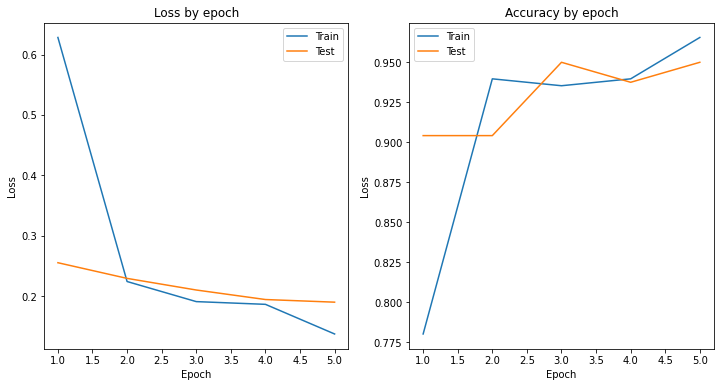

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
epochs = list(range(1, len(history["train_loss"])+1))
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["test_loss"], label="Test")
plt.title("Loss by epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train")
plt.plot(epochs, history["test_acc"], label="Test")
plt.title("Accuracy by epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()